# Assignment 1 Part B - Phoneme Recognition

Welcome to the second part of the assignment! Make sure to read the writeup before beginning work here.

## Setup/Importing

In [13]:
# TODO: Run this cell and follow instructions to connect this notebook to Google Drive
# Additional guidance: https://colab.research.google.com/notebooks/io.ipynb

try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not on google drive")

Mounted at /content/drive


In [14]:
# TODO: Change directories ("cd") to the folder containing your
# notebook and data folder by replacing the filepath below
%cd /content/drive/MyDrive/ALL/ML_DL_DS/CMU_Deep_Learning/Assignment_1b/

/content/drive/MyDrive/ALL/ML_DL_DS/CMU_Deep_Learning/Assignment_1b


In [15]:
# TODO Run this cell to download the data from Amazon AWS
# TODO If needed, replace your the local Google Drive path (/content/drive/MyDrive/pa1b/) with a path that works for you

# !wget -P /content/drive/MyDrive/ALL/ML_DL_DS/CMU_Deep_Learning/Assignment_1b/Data https://cmu-dele-leaderboard-us-east-2-003014019879.s3.us-east-2.amazonaws.com/colab/pa1b/data1pb.zip

In [16]:
# TODO Run this cell to unzip the data from Amazon AWS to your local Drive
# TODO If needed, replace your the local Google Drive path (/content/drive/MyDrive/pa1b/data1pb.zip) with a path that works for you


# !unzip /content/drive/MyDrive/ALL/ML_DL_DS/CMU_Deep_Learning/Assignment_1b/Data/data1pb.zip

In [17]:
# TODO: Run this cell to import packages
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Auto-detect if GPU is available

In [18]:
# TODO: Run this cell to automatically detect if GPU is available.
# Output should be 'cuda' if you are expecting to be on a GPU
# If the output is equal to 'cpu', click on 'Runtime' in the top menu, then 'Change Runtime Type', and select 'GPU'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


# Section 1: `Dataset`/`DataLoader`

When working with any dataset in `torch`, you'll almost always work with a `Dataset` and `DataLoader` object. Here's an overview of what they usually do:

`torch.utils.data.Dataset`
- Stores dataset (usually a single tensor or list of tensors) inside the object
    - Happens in `__init__()` function
- Defines how many observations are in the dataset
    - In `__len__()`
- Defines how to retrieve a single observation from the dataset given its index from 0 inclusive to `__len__()` exclusive
    - In `__getitem__()`


`torch.utils.data.DataLoader`
- Queries and batches observations from an initialized `Dataset`
- If `shuffle=True`, shuffles dataset for you every epoch (do this for training, not validation / testing)
- Handles basic multiprocessing

Some specialized datasets (like in this assignment) usually need a custom `Dataset` class. However, for popular datasets, there are often existing implementations, like those found [here](https://pytorch.org/vision/stable/datasets.html).

## Question 1.1: Initialize Dataset
Fortunately we've already written the custom `Dataset` for you.

Open `utils.py`, find `KContextSpectrograms`, and read through it to understand how it works and what initialization parameters are required. Afterwards, complete and run each cell marked with `# TODO`.

In [19]:
pwd

'/content/drive/MyDrive/ALL/ML_DL_DS/CMU_Deep_Learning/Assignment_1b'

In [20]:
from utils_ import num_ms

# TODO: Specify the desired number of context frames to concatenate to each side of your target,
# then run this cell to preview how many milliseconds will be covered with your selected `k`
k = 38

print(f"# milliseconds covered with context {k}:", num_ms(k))

# milliseconds covered with context 38: 795


In [21]:
cd data

/content/drive/MyDrive/ALL/ML_DL_DS/CMU_Deep_Learning/Assignment_1b/data


In [22]:
# TODO: Initialize dataset objects for training, validation, and testing.
from utils_ import KContextSpectrograms

train_dataset = KContextSpectrograms(data_path = 'train.npy', labels_path = 'train_labels.npy', k=k)
val_dataset = KContextSpectrograms(data_path = 'val.npy', labels_path = 'val_labels.npy', k=k)
test_dataset = KContextSpectrograms(data_path = 'test.npy', labels_path = None, k=k)

## Question 1.2: Initialize DataLoaders
Although `Dataset`s frequently need custom implementations, `DataLoader`s are usually standard.

Use [this documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to guide you on implementing the following instructions:

- Specify an adequate batch size (see writeup)
- Initialize training dataloader with batch size, pinned memory, number of workers, and with shuffling.
- Initialize validation dataloader and test dataloader with your batch size, pinned memory, number of workers, and WITHOUT shuffling.
    - We don't shuffle val because we're just calculating the accuracy on every observation, so shuffling just slows things down without mattering
    - We don't shuffle test because we need to export our predictions in the correct order
    - We use num_workers equal to cpu count to prepare data in parallel
    - We pin memory to speed up data transfer

**Hint**: For examples of initializing `Dataset`s/`DataLoader`s, see [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [23]:
from torch.utils.data import DataLoader

# TODO: Specify how many observations should go in each batch
batch_size = 1024

# pass num_workers into each dataloader
num_workers = os.cpu_count()

# TODO: Initialize `Dataloader` objects for training, validation, and testing.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Section 2: Training/Validation/Prediction Routines

Below are a few given methods that should look familiar, but there are some important differences you should try to spot. Read these through carefully.

In [24]:
# [Given] ALREADY COMPLETED, SHOWN JUST FOR YOUR REFERENCE
def train(model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs):
    """[Given] Trains and validates network for `num_epochs`

    Args:
        model (nn.Sequential): Initialized network, stored in an `nn.Sequential` object.
        optimizer (optim.Optimizer): Initialized optimizer like `optim.SGD` or `optim.Adam`
        scheduler (optim.lr_scheduler): Initialized scheduler like `optim.lr_scheduler.ReduceLROnPlateau` (or None)
        train_dataloader (torch.utils.data.DataLoader): Initialized training dataloader
        val_dataloader (torch.utils.data.DataLoader): Initialized validation dataloader
        num_epochs (int): # epochs to train for
    Returns:
        list, list: losses is the loss per every batch, val_accuracies is the val accuracy per epoch
    """
    losses = []
    val_accuracies = []

    for e in range(num_epochs):
        # No need to manually reshuffle; `Dataloader` handles that for you!
        # Train model for one epoch
        epoch_losses = train_epoch(model, optimizer, train_dataloader, scheduler)
        losses.extend(epoch_losses)

        # Evaluate model on validation set, track accuracy
        val_accuracy = validate(model, val_dataloader)
        print(100 * val_accuracy)
        val_accuracies.append(val_accuracy)

    return losses, val_accuracies

In [25]:
# [Given] ALREADY COMPLETED, SHOWN JUST FOR YOUR REFERENCE
def validate(model, dataloader):
    """[Given] Evaluates network and calculates accuracy for a full validation dataset.

    Args:
        model (nn.Sequential): Your initialized network, stored in a `Sequential` object.
        dataloader (torch.utils.data.DataLoader): Initialized validation dataloader

    Returns:
        float: Accuracy rate for entire val set.
    """
    # Set model to evaluate mode (train mode is `.train()`)
    model.eval()

    total_correct = 0
    # Run loop with `tqdm` progress bar
    for i, (data, labels) in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
        # Put tensors on specified device (GPU or CPU)
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        logits = model(data)
        num_correct = (logits.argmax(axis=1) == labels).cpu().numpy().sum()
        total_correct += num_correct
    return total_correct / len(dataloader.dataset)

## Question 2.1: `train_epoch()`

Now to write the training routine of a single epoch.

See the `validate()` method especially for hints, section 4 [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is also a good reference.

```
def train_epoch():
    set_model_to_train_mode()
    loss_function = create_loss_function_object() # cross entropy!
    for (data, labels) in tqdm(dataloader):
        data, labels = put_tensors_on_appropriate_device(DEVICE, data, labels) # See val method for hint
        reset_gradients_to_zero()
        logits = forward_pass_through_model(model, data)
        loss = loss_function(logits, labels)
        run_backprop() # look up how torch does this; it's slightly different from what you did in part A
        update_model_params() # using the optimizer
        store_loss_value(loss)
    return loss_values
```

In [26]:
import torch
import tqdm

def train_epoch(model, optimizer, dataloader, scheduler=None):
    """Train model for one epoch.

    Args:
        model (nn.Sequential): Initialized network, stored in a `nn.Sequential` object.
        optimizer (optim.Optimizer): Initialized optimizer like `optim.SGD` or `optim.Adam`
        dataloader (torch.utils.data.DataLoader): Initialized training dataloader
        scheduler (optim.lr_scheduler): Optional scheduler if you want it

    Returns:
        list: Loss value of each batch for this epoch.
    """
    # Set the model to training mode
    model.train()

    # Append loss values to this list.
    loss_per_batch = []

    # Run loop with `tqdm` progress bar
    for i, (data, labels) in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
        # Move data and labels to the GPU if available
        data, labels = data.to(DEVICE), labels.to(DEVICE)  # Assuming `device` is correctly set

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(data)

        # Compute the loss
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Update the model's parameters
        optimizer.step()

        # Store the loss value for the batch
        loss_per_batch.append(loss.item())

    # (Feel free to change) If scheduler, determine if we should change LR based on some metric
    if scheduler is not None:
        scheduler.step(sum(loss_per_batch)) # This assumes ReduceLROnPlateau; the choice of using sum is fairly arbitrary.

    return loss_per_batch


## Question 2.2: `predict()`

This method is very similar to the `validate()` method we gave above. It's used to generate predictions for all observations in the test dataset.

You can assume that the dataloader is NOT shuffled. Each batch you receive will have `batch_size` number of observations (no labels), and you want to `extend` a list containing your previous predictions. The end result will be a 1-dimensional list containing integers, the same length as the test dataset.

In [27]:
import torch
import tqdm

def predict(model, dataloader):
    """Generates predictions for the test dataset.

    Args:
        model (nn.Sequential): Your initialized network, stored in a `Sequential` object.
        dataloader (torch.utils.data.DataLoader): Initialized test dataloader

    Returns:
        list: should be the same length as the test dataset, and containing ints (or numpy integers)
    """
    model.eval()

    preds = []
    for i, data in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
        data = data.to(DEVICE)  # Assuming you have defined the DEVICE variable

        # Forward pass to get the logits
        with torch.no_grad():
            logits = model(data)

        # Get the predicted class (assuming a classification task)
        predicted = torch.argmax(logits, dim=1)

        # Extend the preds list with the predicted values
        preds.extend(predicted.cpu().numpy())  # Convert to numpy array and move to CPU

    return preds


# Section 3: Training

You're done with the major coding work! Now just to initialize your model/optimizer and begin training.

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

# TODO: Define your model architecture
model = nn.Sequential(
                      nn.Linear(3080, 1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024, 1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024, 1024),
                      nn.BatchNorm1d(1024),
                      nn.ReLU(),
                      nn.Linear(1024, 512),
                      nn.BatchNorm1d(512),
                      nn.ReLU(),
                      nn.Linear(512, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU(),
                      nn.Linear(256, 256),
                      nn.BatchNorm1d(256),
                      nn.ReLU()
)

# TODO: Put your model on `DEVICE` (e.g., "cuda:0" for GPU or "cpu" for CPU)
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

# TODO: Initialize your optimizer (e.g., Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate as needed

# TODO: (optional) Initialize scheduler if you want to use learning rate scheduling

In [29]:
# TODO: Call your training routine for some epochs (train)
num_epochs = 10

losses, val_accuracies = train(model=model,
                               optimizer=optimizer,
                               scheduler = None,
                               train_dataloader = train_dataloader,
                               val_dataloader = val_dataloader,
                               num_epochs = num_epochs)

100%|██████████| 1523/1523 [00:43<00:00, 34.96it/s]


73.94861124384803


100%|██████████| 1523/1523 [00:41<00:00, 36.55it/s]


74.52338176218059


100%|██████████| 1523/1523 [00:41<00:00, 36.60it/s]


74.44172984053822


100%|██████████| 1523/1523 [00:42<00:00, 36.16it/s]


74.29580829950412


100%|██████████| 1523/1523 [00:41<00:00, 36.30it/s]


74.0056328921906


100%|██████████| 1523/1523 [00:44<00:00, 33.98it/s]


73.79370991567339


100%|██████████| 1523/1523 [00:43<00:00, 35.32it/s]


73.54420011583926


100%|██████████| 1523/1523 [00:42<00:00, 35.57it/s]


73.40591139387463


100%|██████████| 1523/1523 [00:43<00:00, 34.67it/s]


73.27923225385602


100%|██████████| 1523/1523 [00:43<00:00, 35.15it/s]

73.18109600867703


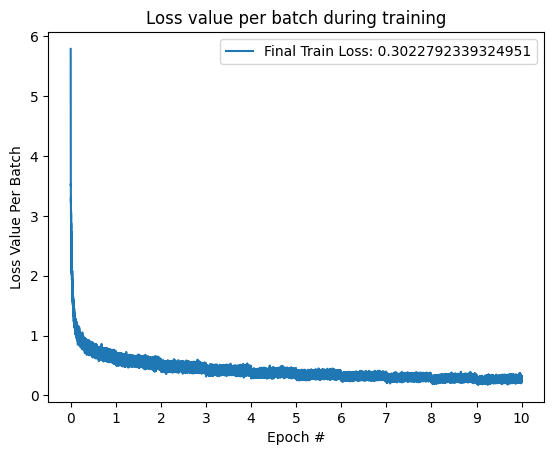

In [30]:
# [GIVEN] You can plot your training loss progress using this function below.
from utils_ import plot_loss

plot_loss(losses, num_batches=len(train_dataloader), num_epochs=20)

# Section 4: Predict Test Dataset and Submission

If you're ready to submit, run these cells below and look for the output file generated in the `submissions/` folder (it will be time-stamped).

**NOTE:** The first row of the CSV should look like this:

`Id,Category`

**Please remember to edit the second entry of the first row ('Category') to the name you want to appear on the leaderboard.**

*e.g.* `Id, deepLearner`

In [31]:
preds = predict(model, test_dataloader)

100%|██████████| 1581/1581 [00:33<00:00, 47.64it/s]


In [ ]:
preds.rename({'label':'Adrian'}, inplace = True)

In [33]:
from utils_ import export_predictions_to_csv

export_predictions_to_csv(preds)

Wrote predictions to submissions/submission_2023-09-17 22:06:58.454982.csv


Change col name

In [7]:
import pandas as pd
def name(file_name, count):
  df_1 = pd.read_csv(file_name)
  df_1.rename(columns = {'label':'Adrian K'}, inplace = True)
  df_1.to_csv(f'Adrian_Kazi_submission_{count}.csv')
  return df_1

name('submission_2023-09-17 18_47_42.179163.csv', 1)
name('submission_2023-09-17 22_06_58.454982.csv', 2)

,id,Adrian K
0,0,22
1,1,31
2,2,13
3,3,58
4,4,57
...,...,...
1618830,1618830,46
1618831,1618831,37
1618832,1618832,0
1618833,1618833,43
